# **Nature Datacube**

## Steps to use Docker image to run Rasterframes

**1 Install Docker**

1.1 Go to https://docs.docker.com/docker-for-windows/install/

1.2 Scroll down to "Install Docker Desktop on Windows" and follow the steps below

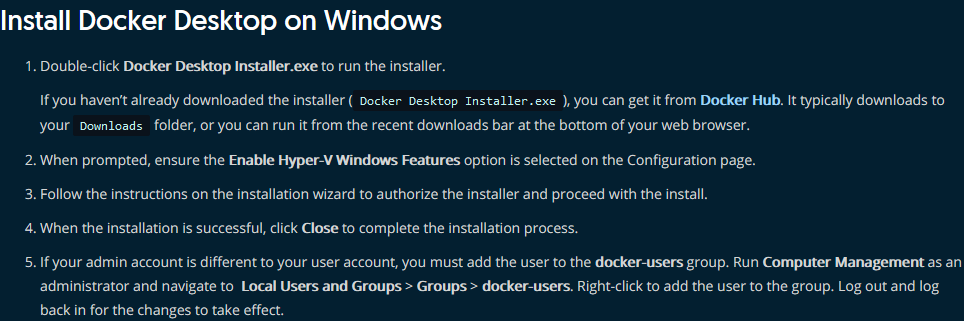

1.3 Run the docker image in windows command prompt (Start->cmd): docker pull s22s/rasterframes-notebook

1.4 Run a container with image in windows command prompt (example): docker run -p 8808:8888 -p 44040:4040 -v s22s/rasterframes-notebook s22s/rasterframes-notebook:latest
    Select your own working directory following -v

1.5 Run Jupyterlab from internet browser: localhost:8808/lab

1.6 Download "NDC_Demonstrator.ipynb" from from GitLab to your working directory, open (click on "upload" icon in upper left menu of Jupyterlab interface) and follow steps from section "Data manipulation in Rasterframes"

## Data manipulation in Rasterframes

Steps and options to select:
1.	Select product from the list: A) Source datasets: LGN, BKN, Sentinel2, TOP10NL, BRP B) Derived products: NDVI
2.	Select spatial extent in form [xmin, xmax, ymin, ymax]
3.	Select time step (year)
4.	Select data format: raster or vector
5.	Select spatial resolution - size of pixel [m]
6.	Select projection: RD new or WGS84
7.  Create mask


### Data input and output options

Replace string in cell below with given options inside the quotes ("")

In [53]:
dataset_input = "brp" # select from following datasets to obtain processed output: lgn, bkn, top10nl, brp, s2, ndvi
extent_input = [6.42,6.51,53.05,53.09] # Input in lat/lon: xmin,xmax,ymin,ymax. Please note that in this demonstrator for vector layers (top10nl, brp) has to be selected smaller area in limited area between within [6.42,6.51,53.05,53.09]
time_step_input = "2019" # Select year: "2018" or "2019" (if dataset is bkn, year has to be 2013)
data_format_input = "raster" # "raster" or "vector" (has to be "raster" in this demonstrator since only vector to raster conversion is available)
resolution_input = "25" # Target cell size im metres
projection_input = "EPSG:4326" # Deafult is WGS84 - web mercator which has code "EPSG:4326", for specific projection see: www.epsg.io or spatialreference.org 
lu_mask_input = "all" # Select from following land use category to create mask: "Nature", "Agriculture", "Urban", "Infrastructure", "Water" 

### Run whole notebook: Menu -> Run -> Run All Cells

In [40]:
# Import modules and packages
import os
import pandas as pd
import geopandas
from builtins import round

from pyspark.sql.functions import *
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import *
import pyrasterframes.rf_ipython

from pyspark.sql import SparkSession
from pyspark.sql import Row

spark = SparkSession.builder \
    .config("spark.driver.memory", "8g")

# spark = create_rf_spark_session()
spark = create_rf_spark_session("local[4]")

In [54]:
# Convert inputs to right formats
dataset = dataset_input
projection = projection_input
resolution = int(resolution_input)
year = int(time_step_input)
extent = extent_input
xmin = extent[0]
xmax = extent[1]
ymin = extent[2]
ymax = extent[3]

In [4]:
# Create raster catalogs
lgn_catalog = spark.createDataFrame([Row(year='2018', layer='https://naturedc.s3.eu-central-1.amazonaws.com/data/lgn2018.tif'),Row(year='2019', layer='https://naturedc.s3.eu-central-1.amazonaws.com/data/lgn2019.tif')])
bkn_catalog = spark.createDataFrame([Row(year='2018', layer='https://naturedc.s3.eu-central-1.amazonaws.com/data/bkn2018.tif'),Row(year='2019', layer='https://naturedc.s3.eu-central-1.amazonaws.com/data/bkn2019.tif')])
s2_catalog = spark.createDataFrame([Row(year='2018', layer='https://naturedc.s3.eu-central-1.amazonaws.com/data/s22018.tif'),Row(year='2019', layer='https://naturedc.s3.eu-central-1.amazonaws.com/data/s22019.tif')])

#### Raster inputs

In [5]:
def raster_function(dataset):
    if dataset == 'lgn' or dataset == 'bkn':
        # Raster block
        resolution = int(resolution_input)
        # Read raster
        catalog = eval(dataset+'_catalog')
        cubedataset = spark.read.raster(catalog,catalog_col_names=['layer'])
        cubedataset = cubedataset.filter(cubedataset.year == year)
        # Make subset
        cubedataset = cubedataset.withColumn('crs_rd_new', rf_mk_crs('EPSG:28992')) \
                    .withColumn('box',st_makeBox2D(st_point(lit(xmin),lit(ymin)), st_point(lit(xmax),lit(ymax)))) \
                    .withColumn('box_rd_new',st_reproject('box',lit('EPSG:4326'),lit('EPSG:28992'))) \
                    .withColumn('extent',rf_extent('layer'))
        # Make subset as an intersect of raster and defined bounding box
        cubedataset = cubedataset.filter(st_intersects('box_rd_new', rf_geometry('layer'))) 
        # Resample
        # Calculate cellsize in m - given that crs is in metres
        from builtins import round
        cubedataset = cubedataset.select('layer','extent','extent.*')
        cubedataset = cubedataset.withColumn('dims',rf_dimensions('layer'))
        cubedataset = cubedataset.withColumn('cellsize',(cubedataset['xmax']-cubedataset['xmin'])/cubedataset['dims.rows'])
        cubedataset = cubedataset.withColumn('crs', rf_mk_crs('EPSG:28992'))
        cellsize = int(round(cubedataset.first()['cellsize']))
        # Calculate aggregated extent
        agg_extent = cubedataset.select(rf_agg_extent('extent')).distinct()
        agg_extent = agg_extent.select('rf_agg_extent(extent).*')
        # Get limits of raster
        xmin_sub = agg_extent.first()['xmin']
        xmax_sub = agg_extent.first()['xmax']
        ymin_sub = agg_extent.first()['ymin']
        ymax_sub = agg_extent.first()['ymax']
        # Calculate raster size - columns and rows
        ncols = (xmax_sub - xmin_sub) / cellsize
        nrows = (ymax_sub - ymin_sub) / cellsize
        # Calculate cell rescale factor
        resolution = int(resolution)
        cs_factor = resolution / cellsize
        # Get rescaled raster dimensions
        ncols_resampled = int(round(ncols / cs_factor))
        nrows_resampled = int(round(nrows / cs_factor))
        # Export raster to GeoTiff
        outfile = os.path.join('/home/jovyan/work/data', 'output_'+dataset+'_'+str(year)+'.tif')
        cubedataset.write.geotiff(outfile, crs = projection,raster_dimensions=(ncols_resampled,nrows_resampled))
        print('Layer "output_'+dataset+'_'+str(year)+'.tif" is stored in working directory.')
    else:
        print('Skipping raster data processing path...')
      
raster_function(dataset)

Skipping raster data processing path...


#### Vector inputs

In [6]:
def vector_function(dataset):
    if dataset == 'top10nl' or dataset == 'brp':
        if dataset == 'brp':
            field = 'GWS_GEWASC'
        else:
            field = 'TDN_CODE'
        field

        if dataset == 'top10nl':
            if year == 2018:
                vector = 'https://naturedc.s3.eu-central-1.amazonaws.com/data/top10nl2018.geojson'
            else:
                vector = 'https://naturedc.s3.eu-central-1.amazonaws.com/data/top10nl2019.geojson'
        elif dataset == 'brp':
                if year == 2018:
                    vector = 'https://naturedc.s3.eu-central-1.amazonaws.com/data/brp2018.geojson'
                else:
                    vector = 'https://naturedc.s3.eu-central-1.amazonaws.com/data/brp2019.geojson'   

        cubevector = geopandas.read_file('https://naturedc.s3.eu-central-1.amazonaws.com/data/brp2019.geojson')
        cubevector = spark.createDataFrame(cubevector)
        cubevector = cubevector.select('geometry',field)
        bound_raster = spark.read.raster('https://naturedc.s3.eu-central-1.amazonaws.com/data/lgn2018.tif')
        cubedataset = bound_raster.withColumn('crs',rf_crs('proj_raster'))
        # Vector to raster
        cubedataset = cubedataset.crossJoin(cubevector)
        cubedataset = cubedataset.filter(st_intersects('geometry', rf_geometry('proj_raster'))) \
                                        .withColumn('target', rf_rasterize('geometry', rf_geometry('proj_raster'), field, rf_dimensions('proj_raster').cols, rf_dimensions('proj_raster').rows)) \
                                        .withColumn('extent',rf_extent('proj_raster'))
        # Make subset
        cubedataset = cubedataset.withColumn('crs_rd_new', rf_mk_crs('EPSG:28992')) \
                    .withColumn('box',st_makeBox2D(st_point(lit(xmin),lit(ymin)), st_point(lit(xmax),lit(ymax)))) \
                    .withColumn('box_rd_new',st_reproject('box',lit('EPSG:4326'),lit('EPSG:28992')))
        # Make subset as an intersect of raster and defined bounding box
        cubedataset = cubedataset.filter(st_intersects('box_rd_new', rf_geometry('proj_raster'))) 
        # Resample
        # Calculate cellsize in m - given that crs is in metres
        from builtins import round
        cubedataset = cubedataset.select('target','extent','extent.*')
        cubedataset = cubedataset.withColumn('dims',rf_dimensions('target'))
        cubedataset = cubedataset.withColumn('cellsize',(cubedataset['xmax']-cubedataset['xmin'])/cubedataset['dims.rows'])
        cubedataset = cubedataset.withColumn('crs', rf_mk_crs('EPSG:28992'))
        cellsize = int(round(cubedataset.first()['cellsize']))
        # Calculate aggregated extent
        agg_extent = cubedataset.select(rf_agg_extent('extent')).distinct()
        agg_extent = agg_extent.select('rf_agg_extent(extent).*')
        # Get limits of raster
        xmin_sub = agg_extent.first()['xmin']
        xmax_sub = agg_extent.first()['xmax']
        ymin_sub = agg_extent.first()['ymin']
        ymax_sub = agg_extent.first()['ymax']
        # Calculate raster size - columns and rows
        ncols = (xmax_sub - xmin_sub) / cellsize
        nrows = (ymax_sub - ymin_sub) / cellsize
        resolution = 25
        # Calculate cell rescale factor
        resolution = int(resolution)
        cs_factor = resolution / cellsize
        # Get rescaled raster dimensions
        ncols_resampled = int(round(ncols / cs_factor))
        nrows_resampled = int(round(nrows / cs_factor))
        # Export raster to GeoTiff

        outfile = os.path.join('/home/jovyan/work/data', 'output_'+dataset+'_'+str(year)+'.tif')
        cubedataset.write.geotiff(outfile, crs = projection,raster_dimensions=(ncols_resampled,nrows_resampled))
        print('Layer "output_'+dataset+'_'+str(year)+'.tif" is stored in working directory.')
    else:
        print('Skipping vector data processing path...')
      
vector_function(dataset)

Skipping vector data processing path...


#### EO image inputs

In [7]:
def image_function(dataset):
    if dataset == 's2' or dataset == 'ndvi':
        # Raster block
        catalog = eval(dataset+'_catalog')
        cubedataset = spark.read.raster(catalog,catalog_col_names=['layer'],band_indexes=[0, 1, 2, 3],)
        cubedataset = cubedataset.filter(cubedataset.year == year)
        cubedataset = cubedataset.withColumnRenamed('layer_b0','blue').withColumnRenamed('layer_b1','green').withColumnRenamed('layer_b2','red').withColumnRenamed('layer_b3','nir')

        # Make subset
        cubedataset = cubedataset.withColumn('crs_rd_new', rf_mk_crs('EPSG:28992')) \
                    .withColumn('box',st_makeBox2D(st_point(lit(xmin),lit(ymin)), st_point(lit(xmax),lit(ymax)))) \
                    .withColumn('box_rd_new',st_reproject('box',lit('EPSG:4326'),lit('EPSG:28992'))) \
                    .withColumn('extent',rf_extent('nir'))
        # Make subset as an intersect of raster and defined bounding box
        cubedataset = cubedataset.filter(st_intersects('box_rd_new', rf_geometry('nir')))

        # Resample
        # Calculate cellsize in m - given that crs is in metres
        from builtins import round
        cubedataset = cubedataset.select('blue','green','red','nir','extent','extent.*')
        cubedataset = cubedataset.withColumn('dims',rf_dimensions('nir'))
        cubedataset = cubedataset.withColumn('cellsize',(cubedataset['xmax']-cubedataset['xmin'])/cubedataset['dims.rows'])
        cubedataset = cubedataset.withColumn('crs', rf_mk_crs('EPSG:28992'))
        cellsize = int(round(cubedataset.first()['cellsize']))
        # Calculate aggregated extent
        agg_extent = cubedataset.select(rf_agg_extent('extent')).distinct()
        agg_extent = agg_extent.select('rf_agg_extent(extent).*')
        # Get limits of raster
        xmin_sub = agg_extent.first()['xmin']
        xmax_sub = agg_extent.first()['xmax']
        ymin_sub = agg_extent.first()['ymin']
        ymax_sub = agg_extent.first()['ymax']
        # Calculate raster size - columns and rows
        ncols = (xmax_sub - xmin_sub) / cellsize
        nrows = (ymax_sub - ymin_sub) / cellsize
        # Calculate cell rescale factor
        #resolution = int(resolution)
        cs_factor = resolution / cellsize
        # Get rescaled raster dimensions
        ncols_resampled = int(round(ncols / cs_factor))
        nrows_resampled = int(round(nrows / cs_factor))
        if dataset == 'ndvi':
            cubedataset = cubedataset.withColumn('NDVI', rf_normalized_difference('nir','red'))
            # Select only NDVI
            cubedataset = cubedataset.select('NDVI')
            # Export
            outfile = os.path.join('/home/jovyan/work/data', 'imagendvi_test1.tif')
            cubedataset.write.geotiff(outfile, crs = projection,raster_dimensions=(256,256))
        else:
            pass
        # Export raster to GeoTiff
        import os
        outfile = os.path.join('/home/jovyan/work/data', 'output_'+dataset+'_'+str(year)+'.tif')
        cubedataset.write.geotiff(outfile, crs = projection,raster_dimensions=(ncols_resampled,nrows_resampled))
        print('Layer "output_'+dataset+'_'+str(year)+'.tif" is stored in working directory.')
    else:
        print('Skipping EO image processing path...')
      
image_function(dataset)

Layer "output_s2_2018.tif" is stored in working directory.
